# Classifying Player Positions

Once seen the main features of clustering, the next step is to switch from an unsupervised to a supervised domain, where we have labels that might be used (for instance) for classification purposes. In the example of shooters, the obtained clusters were not a gold standard that "everyone" is aware of; instead, if we have labelled data, we can build a model able to classify players' positions according to their corresponding true class: PG / SG / SF / PF / C. Although this 5 well-established positions doesn't seem to exist as such anymore, we can still build this model including data from previous years; besides, the performance of the testing process might be useful to indicate whether if these classes do or don't make sense. 

In [18]:
import pandas as pd
import numpy as np
from sklearn import svm

### Data Preparation
The first part, as always, includes data loading and filtering. In this example, we'll load a csv file containing individual player features (its computation is not included in the scope of this Notebook, but let me know if you are really interested); in particular, 10 features have been used to define each player: (1) 3-point Proficiency, (2) Offensive Load, (3) True Shooting percentage, (4) FTA/FGA, (5) Offensive and (6) Defensive Rebouding Percentage, (7) Assist Ratio, (8) Turnover Ratio, (9) Steal Ratio, and (10) (2FG/2FGA) of the opponent team. The latter is an experimental feature that attempts to provide the vector with a little bit more of detail of the player defensive impact.  
Around 300 players from Euroleague teams (2016-2019) have been manually tagged. Note that a single label might correspond to different instances: there is one feature vector / player / season and a single label / player. 

In [19]:
sFolder = '/Users/arbues/Documents/UCAM/Euroleague-Notebooks/Data/'
featureVecsPd = pd.read_csv(sFolder + "FeatVecsIndSC.csv",delimiter=';')
featureVecs = featureVecsPd.iloc[:,1:].to_numpy()
playerNames = featureVecsPd.iloc[:,0].to_numpy()

# Get Pre-Tagged Labels
labNames = np.load(sFolder + 'PBP2016-2018PlayersOut.npy')
labNames = list(labNames)
labPos = np.load(sFolder + 'PBP2016-2018PosOut.npy')

Let's check an example of feature - position: 

In [20]:
sPlayer = 'CLYBURN, WILL'
sYear = '2018'
sTeam = 'CSK'

print(sPlayer + ' Position: ' + str(labPos[labNames.index(sPlayer)]))
print(sPlayer + ' Features: ' + str(featureVecs[list(playerNames).index(sPlayer + ' ' + sYear + ' ' + sTeam)]))

CLYBURN, WILL Position: 34
CLYBURN, WILL Features: [0.3010413  0.31323683 0.56996035 0.45       0.10922787 0.59440559
 0.05921185 0.02550024 0.01795332 0.53679654]


Uh, surprise, huh? What does position 34 mean? 
Since it was really difficult tagging the true position of these players, some of them have 2 numbers, thus indicating that they can switch positions easily. However, at the moment, we'll stick to the basics and just keep the first position / player; besides, since there were wrongly annotated players (with a question mark), some filtering is appreciated. 

In [21]:
featVecsFin = []
namesFin = []
labelsFin = []

# Filter untagged players (label '?')
for iP in range(0, len(playerNames)):
    play = playerNames[iP].split('2')[0][:-1]
    if play in labNames:
        if labPos[labNames.index(play)][0] != '?':
            featVecsFin.append(featureVecs[iP])
            namesFin.append(playerNames[iP])
            # Some players have two labels (e.g. '21'), but we'll only load the first (main) position
            labelsFin.append(int(labPos[labNames.index(play)][0])) 

Once filtered, we could already train our model, but first, we'll sort randomly the obtained feature vectors and split the dataset into train and test, which is a must in order to double-check that there's no overfitting in the training process. This means that, when training the model, around 80% of the instances will be shown to the classifier, but in order to test its accuracy, the remaining 20% will be used. If you didn't get a thing while reading this paragraph, I suggest you to browse the internet and read some related literature (like Bishop's PR book introduction).

In [22]:
# Create the shuffler
posAux = np.arange(len(labelsFin))
np.random.shuffle(posAux)
# Shuffle the entire dataset
featVecsFin = np.array(featVecsFin)[posAux]
namesFin = np.array(namesFin)[posAux]
labelsFin = np.array(labelsFin)[posAux]
# Splitting
pTrain = 0.8
posTrain = int(pTrain*len(namesFin))
# Split into train and test (both stats and labels)
featVecs_train = featVecsFin[:posTrain]
featVecs_test = featVecsFin[posTrain:]

labels_train = labelsFin[:posTrain]
labels_test = labelsFin[posTrain:]
names_test = namesFin[posTrain:]

### Classification - Train
We're ready to classify! Scikit-learn has a bunch of possible classifiers to be used in this kind of scenario (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html); I will stick to Support Vector Machines, which solves binary classification problems geometrically by finding the hyperplane that maximizes the margin between classes (as much as possible). 

In [23]:
# Classifier
clf = svm.SVC()
# Train
clf.fit(featVecs_train, labels_train)

SVC()

### Classification - Test

In [24]:
# Test and print accuracy + confusion matrix
iCorrect = 0
# Initialize Confusion Matrix
confMat = np.zeros((len(np.unique(labels_test)),len(np.unique(labels_test))))
allPreds = []
for iTest in range(0, len(featVecs_test)):
    # Predict for new test sample
    pred = clf.predict([featVecs_test[iTest]])
    # Append for posterior visualization
    allPreds.append(pred[0])
    # Add together correct samples
    if pred[0] == labels_test[iTest]:
        iCorrect += 1
    else:
        # Print failure cases
        print(str(names_test[iTest]) + ' - Predicted: ' + str(pred[0]) + ', Real: ' + str(labels_test[iTest]))
    # Fill confusion matrix
    confMat[pred[0]-1, labels_test[iTest]-1] = confMat[pred[0]-1, labels_test[iTest]-1] + 1
# Print performance
print('-----------------')
print('Binary Classification Performance: ' + str(iCorrect/len(labels_test)))
print(confMat)

GIST, JAMES 2010 PAR - Predicted: 3, Real: 4
VILDOZA, LUCA 2018 BAS - Predicted: 2, Real: 1
SMITH, DEVIN 2011 TEL - Predicted: 4, Real: 3
RUDD, VICTOR 2016 TEL - Predicted: 3, Real: 4
KURBANOV, NIKITA 2019 CSK - Predicted: 4, Real: 3
KALINIC, NIKOLA 2015 ULK - Predicted: 4, Real: 3
WANAMAKER, BRAD 2017 ULK - Predicted: 2, Real: 1
GIST, JAMES 2018 PAN - Predicted: 3, Real: 4
KUZMINSKAS, MINDAUGAS 2017 MIL - Predicted: 2, Real: 3
SPANOULIS, VASSILIS 2019 OLY - Predicted: 1, Real: 2
JAMES, MIKE 2017 PAN - Predicted: 2, Real: 1
LLULL, SERGIO 2009 MAD - Predicted: 2, Real: 1
COLE, NORRIS 2017 TEL - Predicted: 1, Real: 2
SAN EMETERIO, FERNANDO 2009 BAS - Predicted: 2, Real: 3
CARROLL, JAYCEE 2012 MAD - Predicted: 3, Real: 2
SUAREZ, CARLOS 2017 MAL - Predicted: 3, Real: 4
SCHILB, BLAKE 2016 GAL - Predicted: 1, Real: 3
MILLER, DARIUS 2016 BAM - Predicted: 2, Real: 4
PNINI, GUY 2013 TEL - Predicted: 2, Real: 3
BLAZIC, JAKA 2014 RED - Predicted: 2, Real: 3
GIST, JAMES 2012 PAN - Predicted: 3, Re

### Visualization
Although ~0.65 doesn't seem to be the best model ever... Have you checked the failure cases? As we were talking about before, (e.g.) Clyburn is a player that could be tagged as a 3 or as a 4, so... Is the model performing poorly? Not for me! When building Machine Learning models, sometimes you don't need to have the best accuracy in a tuned model with hundreds of hyperparameters; instead, sometimes it is worth thinking about the intrinsic details of the given classes and recognize the failure patterns. 

Finally, we can again visualize results in a 2D space by using Principal Component Analysis. This time the color (tags) belong to the true player position class. 

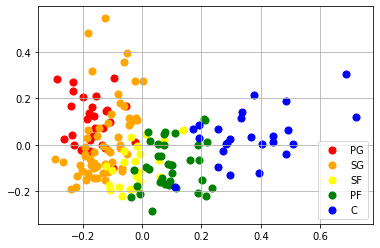

In [25]:
# Visualize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(featVecs_test)

colormaps = ["red", "orange", "yellow", "green", "blue", "black", 'lightgreen','dodgerblue','navy','mediumpurple','pink','hotpink','oldlace','aqua','slategrey','palegreen','m','indianred','orchid']
posS = ['PG','SG','SF','PF','C']
    
allPreds = np.array(allPreds)
for iPos in range(0, 5):
    plt.scatter(principalComponents[allPreds == (iPos+1), 0], principalComponents[allPreds == (iPos+1), 1], s=50, c=colormaps[iPos],  label=posS[iPos])
    
plt.legend(scatterpoints=1, loc='best')
plt.grid()
plt.show()

Hope you liked it! 
If you have any questions / suggestions, feel free to send me an email (adria.arbues@upf.edu) or a Twitter DM (@arbues6). 